# Adaboost

## Setting up

- Wine data
- Binary classification (filter class 0 and 1)
- 2 features ('alcohol','malic_acid')

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import make_scorer

#Load data
dataObj = load_wine()
X = dataObj.data
y = dataObj.target

# Create DataFrame with features
dfori = pd.DataFrame(X)
dfori.columns = dataObj.feature_names

# Add class column
dfori.insert(loc=0, column="Class", value=y)

#Filter class 0 and 1
filt = (dfori['Class'] == 0) | (dfori['Class'] == 1)
df = dfori.loc[filt]

# Extract two features 
X = df[['alcohol','malic_acid']].values
y = df['Class'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)

In [12]:
# Make scorer
scorer_ACC = make_scorer(accuracy_score)
scorer_PRE = make_scorer(precision_score, zero_division=0, pos_label=1)
scorer_REC = make_scorer(recall_score, zero_division=0, pos_label=1)
scorer_F1 = make_scorer(f1_score, pos_label=1)
scorer_ROCAUC = make_scorer(roc_auc_score)

scorings = {'accuracy':scorer_ACC,
            'precision':scorer_PRE,
            'recall': scorer_REC,
            'f1': scorer_F1,
            'rocauc': scorer_ROCAUC}

## Decision tree

In [13]:
from sklearn.tree import DecisionTreeClassifier

# Classifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)

# Training scores
df = pd.DataFrame()

sc = cross_validate(estimator=tree,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        scoring=scorings,
                        n_jobs=-1)
                        
ACC = sc['test_accuracy']
PRE = sc['test_precision']
REC = sc['test_recall']
F1 = sc['test_f1']
ROCAUC = sc['test_rocauc']

data = {'clf': 'Tree (Train)',
        'ACC': f"{ACC.mean():6.3f}",
        'PRE': f"{PRE.mean():6.3f}",
        'REC': f"{REC.mean():6.3f} ",
        'F1': f"{F1.mean():6.3f}",
        'ROCAUC': f"{ROCAUC.mean():6.3f}"}

df = df.append(data, ignore_index=True)
df = df[['clf', 'ACC', 'PRE', 'REC', 'F1', 'ROCAUC']]

# Testing scores
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
y_proba = tree.predict_proba(X_test)

ACC = accuracy_score(y_true=y_test, y_pred=y_pred)
PRE = precision_score(y_true=y_test, y_pred=y_pred, pos_label=1)
REC = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1)
F1 = f1_score(y_true=y_test, y_pred=y_pred, pos_label=1)
ROCAUC = roc_auc_score(y_true=y_test, y_score=y_proba[:,1])

data = {'clf': 'Tree (Test)', 'ACC': ACC, 'PRE': PRE, 'REC': REC, 'F1': F1, 'ROCAUC': ROCAUC}
df = df.append(data, ignore_index=True)
df = df.set_index(['clf'])

display(df)

,ACC,PRE,REC,F1,ROCAUC
clf,,,,,
Tree (Train),0.821,0.834,0.885,0.846,0.822
Tree (Test),0.865385,0.83871,0.928571,0.881356,0.860119


## Adaboost

In [14]:
from sklearn.ensemble import AdaBoostClassifier

base = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=base,
                         n_estimators=500, 
                         learning_rate=1,
                         random_state=1)

In [15]:
# Training scores
df = df.reset_index()

sc = cross_validate(estimator=ada,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        scoring=scorings,
                        n_jobs=-1)
                        
ACC = sc['test_accuracy']
PRE = sc['test_precision']
REC = sc['test_recall']
F1 = sc['test_f1']
ROCAUC = sc['test_rocauc']

data = {'clf': 'Ada (Train)',
        'ACC': f"{ACC.mean():6.3f}",
        'PRE': f"{PRE.mean():6.3f}",
        'REC': f"{REC.mean():6.3f} ",
        'F1': f"{F1.mean():6.3f}",
        'ROCAUC': f"{ROCAUC.mean():6.3f}"}

df = df.append(data, ignore_index=True)

# Testing scores
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
y_proba = ada.predict_proba(X_test)

ACC = accuracy_score(y_true=y_test, y_pred=y_pred)
PRE = precision_score(y_true=y_test, y_pred=y_pred, pos_label=1)
REC = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1)
F1 = f1_score(y_true=y_test, y_pred=y_pred, pos_label=1)
ROCAUC = roc_auc_score(y_true=y_test, y_score=y_proba[:,1])

data = {'clf': 'Ada (Test)', 'ACC': ACC, 'PRE': PRE, 'REC': REC, 'F1': F1, 'ROCAUC': ROCAUC}
df = df.append(data, ignore_index=True)
df = df.set_index(['clf'])

display(df)

,ACC,PRE,REC,F1,ROCAUC
clf,,,,,
Tree (Train),0.821,0.834,0.885,0.846,0.822
Tree (Test),0.865385,0.83871,0.928571,0.881356,0.860119
Ada (Train),0.846,0.862,0.885,0.862,0.847
Ada (Test),0.923077,0.9,0.964286,0.931034,0.990327


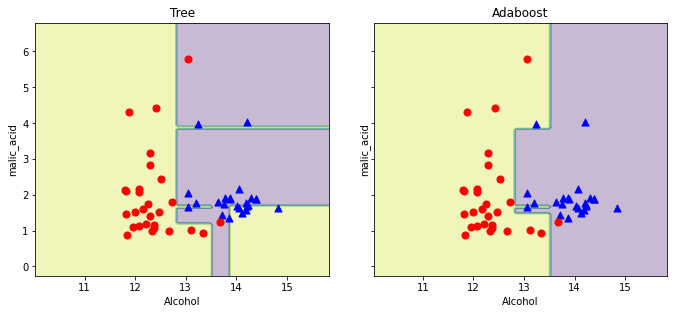

In [16]:
all_clf = [tree, ada]
clf_labels = ["Tree", "Adaboost"]

x_min = X[:, 0].min() - 1
x_max = X[:, 0].max() + 1
y_min = X[:, 1].min() - 1
y_max = X[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(10, 5))

for ax, clf, tt in zip(axarr, all_clf, clf_labels):

    clf.fit(X_train, y_train)    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3)
    
    ax.scatter(X_test[y_test==0, 0], 
                X_test[y_test==0, 1], 
                c='blue', 
                marker='^',
                s=50)
    
    ax.scatter(X_test[y_test==1, 0], 
                X_test[y_test==1, 1], 
                c='red', 
                marker='o',
                s=50)
    
    ax.set_title(tt)
    ax.set_xlabel("Alcohol")
    ax.set_ylabel("malic_acid")

plt.tight_layout(pad=3.0)
plt.show()